# Quantum Protein Folding

In [1]:
import matplotlib.lines as mlines
import dimod
import matplotlib.pyplot as plt
import dynex

In [2]:
# Protein sequence and grid dimensions
sequence = "PPHPPHP" # HP = 7

N = len(sequence)
L = (len(sequence) // 2) + 1 

# Create binary variables for each bead at each grid point (checkerboard pattern)
variables = {(i, j, k): f"x_{i}_{j}_{k}" for i in range(N) for j in range(L) for k in range(L)
             if (j + k) % 2 == i % 2}  # Even/Odd site placement based on bead index

# Define the interaction matrix for the HP model
def interaction(h1, h2):
    return -1 if h1 == 'H' and h2 == 'H' else 0

# Initialize the QUBO dictionary
Q = {}

# Add HP energy terms
for f in range(N):
    for fp in range(f + 2, N):  # Ensure non-adjacent beads in sequence
        if interaction(sequence[f], sequence[fp]) != 0:
            for j in range(L):
                for k in range(L):
                    for jp in range(L):
                        for kp in range(L):
                            if abs(j - jp) + abs(k - kp) == 1:  # Neighbors on the grid
                                if (j + k) % 2 == f % 2 and (jp + kp) % 2 == fp % 2:  # Correct sites
                                    pair = (variables[f, j, k], variables[fp, jp, kp])
                                    if pair in Q:
                                        Q[pair] += interaction(sequence[f], sequence[fp])
                                    else:
                                        Q[pair] = interaction(sequence[f], sequence[fp])

# Constraint to ensure each bead is placed at exactly one location
for i in range(N):
    for j in range(L):
        for k in range(L):
            if (j + k) % 2 == i % 2:
                one_site = [variables[i, jp, kp] for jp in range(L) for kp in range(L) if (jp + kp) % 2 == i % 2 and (jp, kp) != (j, k)]
                for var in one_site:
                    Q[(variables[i, j, k], var)] = Q.get((variables[i, j, k], var), 0) + 2  # Quadratic penalty for being at multiple locations

# Enhanced self-avoidance constraint
for j in range(L):
    for k in range(L):
        beads = [variables[i, j, k] for i in range(N) if (i, j, k) in variables]
        if len(beads) > 1:  # Only necessary if more than one bead could occupy this site
            for b1 in range(len(beads)):
                for b2 in range(b1 + 1, len(beads)):
                    Q[(beads[b1], beads[b2])] = Q.get((beads[b1], beads[b2]), 0) + 10  # Significantly increased penalty for overlap

# Add the connectivity constraint between consecutive beads with increased penalty
for i in range(N - 1):
    for j in range(L):
        for k in range(L):
            if (j + k) % 2 == i % 2:  # Even or odd site based on the bead index
                possible_next_positions = [(jp, kp) for jp in range(L) for kp in range(L)
                                           if abs(j - jp) + abs(k - kp) == 1 and (jp + kp) % 2 == (i + 1) % 2]
                if possible_next_positions:  # Ensure there are possible positions
                    next_bead_vars = [variables[i + 1, jp, kp] for jp, kp in possible_next_positions]
                    # Apply a stronger penalty if not adjacent
                    for next_var in next_bead_vars:
                        Q[(variables[i, j, k], next_var)] = Q.get((variables[i, j, k], next_var), 0) - 3  # Negative for attraction



# Create the Binary Quadratic Model
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)


# ------------- Classical Simulated Annealing Sampler -------------
#sampler = dimod.SimulatedAnnealingSampler()
#sampleset = sampler.sample(bqm, num_reads=100)

# ------------- Dynex -------------
model = dynex.BQM(bqm)
sampler = dynex.DynexSampler(model, mainnet=False, description='Quantum Protein Folding', bnb=False)
sampleset = sampler.sample(num_reads=10000, annealing_time=100, debugging=False)

lowest_energy_sample = sampleset.first.sample

# Extract the positions of the beads from the variable names in the lowest energy sample
positions = {}
for variable_name, value in lowest_energy_sample.items():
    if value == 1:
        # The variable name format is "x_i_j_k", we need to extract i, j, k
        parts = variable_name.split('_')
        i = int(parts[1])
        j = int(parts[2])
        k = int(parts[3])
        positions[i] = (j, k)

positions

[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │       64 │             780 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.41 SECONDS
[DYNEX] SAMPLESET READY


{0: (3, 1), 1: (2, 1), 2: (3, 3), 3: (3, 2), 4: (2, 2), 5: (1, 2), 6: (1, 1)}

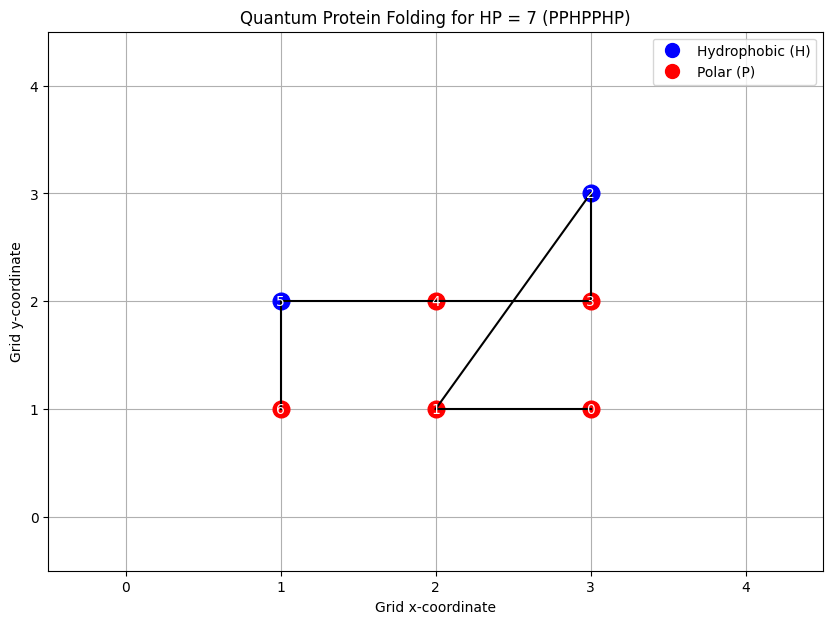

In [3]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 4.5)
ax.set_xticks(range(L+1))
ax.set_yticks(range(L+1))
ax.grid(True)

# Define colors for hydrophobic (H) and polar (P) beads
colors = {'H': 'blue', 'P': 'red'}

# Plot each bead in the sequence and connect with lines
for index in range(len(positions)):
    j, k = positions[index]
    color = colors[sequence[index]]
    ax.plot(j, k, 'o', markersize=12, color=color)  # Plot points
    ax.text(j, k, f'{index}', color='white', ha='center', va='center')  # Label points

    # Draw lines between sequential beads
    if index > 0:
        prev_j, prev_k = positions[index - 1]
        ax.plot([prev_j, j], [prev_k, k], color='black') 
hydrophobic_legend = mlines.Line2D([], [], color='blue', marker='o',
                                   markersize=10, label='Hydrophobic (H)', linestyle='None')
polar_legend = mlines.Line2D([], [], color='red', marker='o',
                             markersize=10, label='Polar (P)', linestyle='None')
ax.legend(handles=[hydrophobic_legend, polar_legend])
ax.set_xlabel('Grid x-coordinate')
ax.set_ylabel('Grid y-coordinate')
ax.set_title('Quantum Protein Folding for HP = 7 ('+sequence+')')
plt.show()